# Softmax exercise
(Adapted from Stanford University's CS231n Open Courseware)

*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission. For more details see the [HW page](http://kovan.ceng.metu.edu.tr/~sinan/DL/index.html) on the course website.*

This exercise is analogous to the SVM exercise. You will:

- implement a fully-vectorized **loss function** for the Softmax classifier
- implement the fully-vectorized expression for its **analytic gradient**
- **check your implementation** with numerical gradient
- use a validation set to **tune the learning rate and regularization** strength
- **optimize** the loss function with **SGD**
- **visualize** the final learned weights


In [1]:
import random
import numpy as np
from cs231n.data_utils import load_CIFAR10
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading extenrnal modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

In [2]:
def get_CIFAR10_data(num_training=18000, num_validation=1000, num_test=1000):
#Increase training if you have memory:
#def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000):
  """
  Load the CIFAR-10 dataset from disk and perform preprocessing to prepare
  it for the linear classifier. These are the same steps as we used for the
  SVM, but condensed to a single function.  
  """
  # Load the raw CIFAR-10 data
  cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'
  X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir,num_of_batches=3)
# Increase num_of_batches to 6 if you have sufficient memory
  
  # subsample the data
  mask = range(num_training, num_training + num_validation)
  X_val = X_train[mask]
  y_val = y_train[mask]
  mask = range(num_training)
  X_train = X_train[mask]
  y_train = y_train[mask]
  mask = range(num_test)
  X_test = X_test[mask]
  y_test = y_test[mask]
  
  # Preprocessing: reshape the image data into rows
  X_train = np.reshape(X_train, (X_train.shape[0], -1))
  X_val = np.reshape(X_val, (X_val.shape[0], -1))
  X_test = np.reshape(X_test, (X_test.shape[0], -1))
  
  # Normalize the data: subtract the mean image
  mean_image = np.mean(X_train, axis = 0)
  X_train -= mean_image
  X_val -= mean_image
  X_test -= mean_image
  
  # add bias dimension and transform into columns
  X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))]).T
  X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))]).T
  X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))]).T
  
  return X_train, y_train, X_val, y_val, X_test, y_test


# Invoke the above function to get our data.
X_train, y_train, X_val, y_val, X_test, y_test = get_CIFAR10_data()
print 'Train data shape: ', X_train.shape
print 'Train labels shape: ', y_train.shape
print 'Validation data shape: ', X_val.shape
print 'Validation labels shape: ', y_val.shape
print 'Test data shape: ', X_test.shape
print 'Test labels shape: ', y_test.shape

Train data shape:  (3073, 18000)
Train labels shape:  (18000,)
Validation data shape:  (3073, 1000)
Validation labels shape:  (1000,)
Test data shape:  (3073, 1000)
Test labels shape:  (1000,)


## Softmax Classifier

Your code for this section will all be written inside **cs231n/classifiers/softmax.py**. 


In [9]:
# First implement the naive softmax loss function with nested loops.
# Open the file cs231n/classifiers/softmax.py and implement the
# softmax_loss_naive function.

from cs231n.classifiers.softmax import softmax_loss_naive
import time

# Generate a random softmax weight matrix and use it to compute the loss.
W = np.random.randn(10, 3073) * 0.0001
loss, grad = softmax_loss_naive(W, X_train, y_train, 0.0)

# As a rough sanity check, our loss should be something close to -log(0.1).
print 'loss: %f' % loss
print 'sanity check: %f' % (-np.log(0.1))

loss: 2.364744
sanity check: 2.302585


## Inline Question 1:
Why do we expect our loss to be close to -log(0.1)? Explain briefly.**

**Your answer:**

Since there are 10 classes in our model and the randomization of the initial weights, we expect it to be uniform distribution. That is close to 1/10. But from the softmax function, we expect it to be close to -log(0.1).

In [12]:
# Complete the implementation of softmax_loss_naive and implement a (naive)
# version of the gradient that uses nested loops.
loss, grad = softmax_loss_naive(W, X_train, y_train, 0.0)

# As we did for the SVM, use numeric gradient checking as a debugging tool.
# The numeric gradient should be close to the analytic gradient.
from cs231n.gradient_check import grad_check_sparse
f = lambda w: softmax_loss_naive(w, X_train, y_train, 0.0)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)

numerical: -1.941007 analytic: -1.941007, relative error: 5.007879e-09


KeyboardInterrupt: 

In [5]:
# Now that we have a naive implementation of the softmax loss function and its gradient,
# implement a vectorized version in softmax_loss_vectorized.
# The two versions should compute the same results, but the vectorized version should be
# much faster.
tic = time.time()
loss_naive, grad_naive = softmax_loss_naive(W, X_train, y_train, 0.00001)
toc = time.time()
print 'naive loss: %e computed in %fs' % (loss_naive, toc - tic)

from cs231n.classifiers.softmax import softmax_loss_vectorized
tic = time.time()
loss_vectorized, grad_vectorized = softmax_loss_vectorized(W, X_train, y_train, 0.00001)
toc = time.time()
print 'vectorized loss: %e computed in %fs' % (loss_vectorized, toc - tic)

# As we did for the SVM, we use the Frobenius norm to compare the two versions
# of the gradient.
grad_difference = np.linalg.norm(grad_naive - grad_vectorized, ord='fro')
print 'Loss difference: %f' % np.abs(loss_naive - loss_vectorized)
print 'Gradient difference: %f' % grad_difference

naive loss: 2.322001e+00 computed in 4.779283s
vectorized loss: 2.322001e+00 computed in 0.233137s
Loss difference: 0.000000
Gradient difference: 0.000000


In [6]:
# Use the validation set to tune hyperparameters (regularization strength and
# learning rate). You should experiment with different ranges for the learning
# rates and regularization strengths; if you are careful you should be able to
# get a classification accuracy of over 0.35 on the validation set.
from cs231n.classifiers import Softmax
results = {}
best_val = -1
best_softmax = None

learning_rates = [1e-7, 5e-7]
regularization_strengths = [5e4, 1e8]

learning_rates = np.arange(10)*1e-8 + 5e-8
learning_rates = np.random.uniform(5e-8, 2e-7, 10)
regularization_strengths = np.arange(5)*5e4 + 1e4
regularization_strengths = np.random.uniform(1e4, 1e5, 10)

learning_rates = [5.70248463e-08 1.69625383e-07 1.96233888e-07 1.16100330e-07
 1.38419988e-07 7.29656628e-08 1.00529596e-07 1.83057673e-07
 1.62309953e-07 1.33960918e-07]
regularization_strengths = [36381.59251777 10758.00819771 19285.78756965 25919.1078636
 10955.56060137 32456.03436295 35046.90613309 68279.08988005
 44813.64079449 92440.67971792]
# print learning_rates, regularization_strengths

################################################################################
# TODO:                                                                        #
# Use the validation set to set the learning rate and regularization strength. #
# This should be identical to the validation that you did for the SVM; save    #
# the best trained softmax classifer in best_softmax.                          #
################################################################################
for lr in learning_rates:
    for reg in regularization_strengths:
        new_softmax = Softmax()
        loss_hist = new_softmax.train(X_train, y_train, learning_rate=lr, reg=reg,
                              num_iters=1500, verbose=False)
        new_train_pred = np.mean(y_train == new_softmax.predict(X_train))
        new_val_pred = np.mean(y_val == new_softmax.predict(X_val))
        results[(lr, reg)] = (new_train_pred, new_val_pred)
        if new_val_pred > best_val:
#             print(new_val_pred)
            best_val = new_val_pred
            best_softmax = new_softmax
################################################################################
#                              END OF YOUR CODE                                #
################################################################################
    
# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print 'lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy)
    
print 'best validation accuracy achieved during cross-validation: %f' % best_val

[5.70248463e-08 1.69625383e-07 1.96233888e-07 1.16100330e-07
 1.38419988e-07 7.29656628e-08 1.00529596e-07 1.83057673e-07
 1.62309953e-07 1.33960918e-07] [36381.59251777 10758.00819771 19285.78756965 25919.1078636
 10955.56060137 32456.03436295 35046.90613309 68279.08988005
 44813.64079449 92440.67971792]
0.324
0.35
0.373
0.384
lr 5.702485e-08 reg 1.075801e+04 train accuracy: 0.274389 val accuracy: 0.269000
lr 5.702485e-08 reg 1.095556e+04 train accuracy: 0.269944 val accuracy: 0.278000
lr 5.702485e-08 reg 1.928579e+04 train accuracy: 0.309556 val accuracy: 0.302000
lr 5.702485e-08 reg 2.591911e+04 train accuracy: 0.332444 val accuracy: 0.350000
lr 5.702485e-08 reg 3.245603e+04 train accuracy: 0.336778 val accuracy: 0.339000
lr 5.702485e-08 reg 3.504691e+04 train accuracy: 0.333167 val accuracy: 0.330000
lr 5.702485e-08 reg 3.638159e+04 train accuracy: 0.339000 val accuracy: 0.324000
lr 5.702485e-08 reg 4.481364e+04 train accuracy: 0.332278 val accuracy: 0.335000
lr 5.702485e-08 reg 6.

In [7]:
# evaluate on test set
# Evaluate the best svm on test set
y_test_pred = best_softmax.predict(X_test)
test_accuracy = np.mean(y_test == y_test_pred)
print 'softmax on raw pixels final test set accuracy: %f' % (test_accuracy, )

softmax on raw pixels final test set accuracy: 0.377000


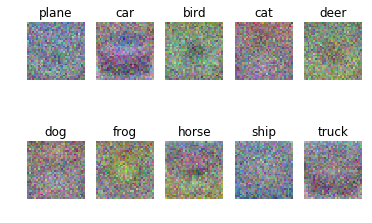

In [8]:
# Visualize the learned weights for each class
w = best_softmax.W[:,:-1] # strip out the bias
w = w.reshape(10, 32, 32, 3)

w_min, w_max = np.min(w), np.max(w)

classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for i in xrange(10):
  plt.subplot(2, 5, i + 1)
  
  # Rescale the weights to be between 0 and 255
  wimg = 255.0 * (w[i].squeeze() - w_min) / (w_max - w_min)
  plt.imshow(wimg.astype('uint8'))
  plt.axis('off')
  plt.title(classes[i])